In [16]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np

# Define Positional Encoding layer
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, max_len, d_model):
        super(PositionalEncoding, self).__init__()
        pos_encoding = np.zeros((max_len, d_model))
        positions = np.arange(max_len)[:, np.newaxis]
        div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))

        pos_encoding[:, 0::2] = np.sin(positions * div_term)
        pos_encoding[:, 1::2] = np.cos(positions * div_term)
        self.pos_encoding = tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:tf.shape(inputs)[1], :]

# Transformer Encoder Block
def transformer_block(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    # Self-attention
    attn_output = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads)(inputs, inputs)
    attn_output = layers.Dropout(dropout)(attn_output)
    attn_output = layers.LayerNormalization(epsilon=1e-6)(attn_output + inputs)  # Residual connection

    # Feed-forward
    ff_output = layers.Dense(ff_dim, activation="relu")(attn_output)
    ff_output = layers.Dropout(dropout)(ff_output)
    ff_output = layers.Dense(inputs.shape[-1])(ff_output)
    ff_output = layers.LayerNormalization(epsilon=1e-6)(ff_output + attn_output)  # Residual connection
    
    return ff_output

# Build Transformer Model
def build_transformer_model(input_shape, head_size, num_heads, ff_dim, num_blocks, num_classes, dropout=0.1):
    inputs = layers.Input(shape=input_shape)

    # Add Positional Encoding
    x = PositionalEncoding(max_len=input_shape[0], d_model=input_shape[1])(inputs)

    # Add Transformer blocks
    for _ in range(num_blocks):
        x = transformer_block(x, head_size, num_heads, ff_dim, dropout)
    
    # Global average pooling
    x = layers.GlobalAveragePooling1D()(x)
    
    # Output layer
    outputs = layers.Dense(num_classes, activation="sigmoid")(x)
    
    model = tf.keras.Model(inputs, outputs)
    return model

# Example usage with your dataset
input_shape = (1, X_train.shape[1])  # Sequence length = 1, num_features = X_train.shape[1]
head_size = 256
num_heads = 4
ff_dim = 256
num_blocks = 2
num_classes = 1  # Binary classification

# Build and compile the model
transformer_model = build_transformer_model(input_shape, head_size, num_heads, ff_dim, num_blocks, num_classes)
transformer_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Summary of the model
transformer_model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 1, 30)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encodin… │ (None, 1, 30)     │          0 │ input_layer_3[0]… │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 1, 30)     │    125,982 │ positional_encod… │
│ (MultiHeadAttentio… │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_25          │ (None, 1, 30)     │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_14 (Add)        │ (None, 1, 30)     │          0 │ dropout_25[0][0], │
│                     │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1, 30)     │         60 │ add_14[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 1, 256)    │      7,936 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_26          │ (None, 1, 256)    │          0 │ dense_20[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 1, 30)     │      7,710 │ dropout_26[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_15 (Add)        │ (None, 1, 30)     │          0 │ dense_21[0][0],   │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1, 30)     │         60 │ add_15[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 1, 30)     │    125,982 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_28          │ (None, 1, 30)     │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_16 (Add)        │ (None, 1, 30)     │          0 │ dropout_28[0][0], │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1, 30)     │         60 │ add_16[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 1, 256)    │      7,936 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_29          │ (None, 1, 256)    │          0 │ dense_22[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 1, 30)     │      7,710 │ dropout_29[0][0]

 Total params: 283,527 (1.08 MB)

 Trainable params: 283,527 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
import pandas as pd
preprocessed_data = pd.read_csv(r'/Users/issackondreddy/Desktop/Projects/Fraud Detection System/DS/data/processed_creditcard.csv')
preprocessed_data.head()

,Scaled_Time,Scaled_Amount,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,-1.996583,0.244964,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-1.996583,-0.342475,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,-1.996562,0.140534,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
3,-1.996541,-0.073403,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0
4,-1.996541,-0.338556,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,...,0.084968,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,0


In [18]:
# Separate features and target
X = preprocessed_data.drop('Class', axis=1)
y = preprocessed_data['Class']

In [19]:
from sklearn.model_selection import train_test_split
# Split the dataset into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)

In [20]:
X_train_reshaped = X_train.values.reshape(X_train.shape[0], 1, X_train.shape[1])
X_val_reshaped = X_val.values.reshape(X_val.shape[0], 1, X_val.shape[1])
X_test_reshaped = X_test.values.reshape(X_test.shape[0], 1, X_test.shape[1])

In [21]:
history = transformer_model.fit(X_train_reshaped, y_train, validation_data=(X_val_reshaped, y_val), epochs=10, batch_size=32)

Epoch 1/10


/Users/issackondreddy/Desktop/Projects/Fraud Detection System/FDS/lib/python3.11/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


7055/7060 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9698 - loss: 0.0795

/Users/issackondreddy/Desktop/Projects/Fraud Detection System/FDS/lib/python3.11/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


7060/7060 ━━━━━━━━━━━━━━━━━━━━ 49s 7ms/step - accuracy: 0.9698 - loss: 0.0795 - val_accuracy: 0.9958 - val_loss: 0.0149
Epoch 2/10
7060/7060 ━━━━━━━━━━━━━━━━━━━━ 42s 6ms/step - accuracy: 0.9902 - loss: 0.0291 - val_accuracy: 0.9953 - val_loss: 0.0122
Epoch 3/10
7060/7060 ━━━━━━━━━━━━━━━━━━━━ 47s 7ms/step - accuracy: 0.9935 - loss: 0.0199 - val_accuracy: 0.9960 - val_loss: 0.0107
Epoch 4/10
7060/7060 ━━━━━━━━━━━━━━━━━━━━ 40s 6ms/step - accuracy: 0.9946 - loss: 0.0168 - val_accuracy: 0.9977 - val_loss: 0.0075
Epoch 5/10
7060/7060 ━━━━━━━━━━━━━━━━━━━━ 40s 6ms/step - accuracy: 0.9952 - loss: 0.0152 - val_accuracy: 0.9989 - val_loss: 0.0047
Epoch 6/10
7060/7060 ━━━━━━━━━━━━━━━━━━━━ 39s 6ms/step - accuracy: 0.9958 - loss: 0.0135 - val_accuracy: 0.9982 - val_loss: 0.0073
Epoch 7/10
7060/7060 ━━━━━━━━━━━━━━━━━━━━ 38s 5ms/step - accuracy: 0.9965 - loss: 0.0119 - val_accuracy: 0.9979 - val_loss: 0.0070
Epoch 8/10
7060/7060 ━━━━━━━━━━━━━━━━━━━━ 38s 5ms/step - accuracy: 0.9969 - loss: 0.0109 - val

In [31]:
X_test_reshaped = X_test.values.reshape(X_test.shape[0], 1, X_test.shape[1])

In [33]:
results = transformer_model.evaluate(X_test_reshaped, y_test)
print(f"Test Loss: {results[0]}, Test Accuracy: {results[1]}")

1513/1513 ━━━━━━━━━━━━━━━━━━━━ 1s 935us/step - accuracy: 0.9985 - loss: 0.0057
Test Loss: 0.005295268725603819, Test Accuracy: 0.9986160397529602


In [35]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

y_pred = (transformer_model.predict(X_test_reshaped) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

auc = roc_auc_score(y_test, y_pred)
print(f"AUC: {auc}")


 118/1513 ━━━━━━━━━━━━━━━━━━━━ 1s 860us/step

/Users/issackondreddy/Desktop/Projects/Fraud Detection System/FDS/lib/python3.11/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


1513/1513 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


/Users/issackondreddy/Desktop/Projects/Fraud Detection System/FDS/lib/python3.11/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     31228
           1       1.00      1.00      1.00     17184

    accuracy                           1.00     48412
   macro avg       1.00      1.00      1.00     48412
weighted avg       1.00      1.00      1.00     48412

[[31169    59]
 [    8 17176]]
AUC: 0.9988225602816934


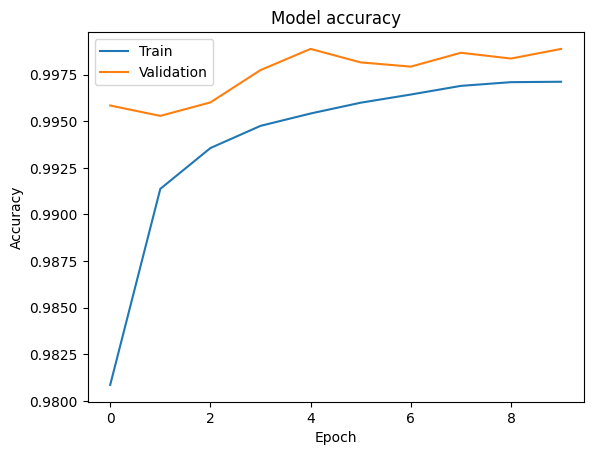

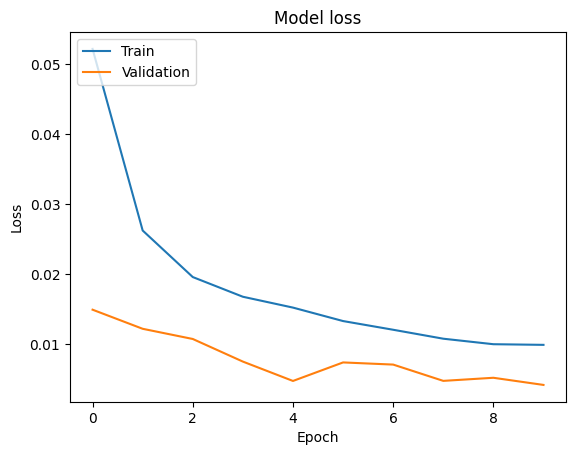

In [24]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


1513/1513 ━━━━━━━━━━━━━━━━━━━━ 1s 923us/step


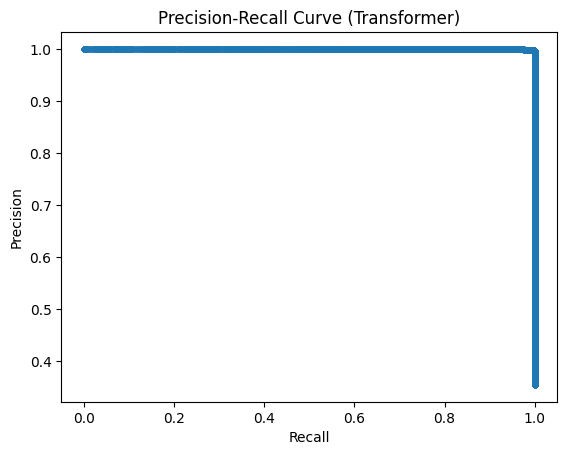

In [36]:
from sklearn.metrics import precision_recall_curve

# Get predictions for the test set
y_pred_probs = transformer_model.predict(X_test_reshaped).ravel()

# Calculate precision-recall values
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_probs)

# Plot precision-recall curve
plt.plot(recall, precision, marker='.')
plt.title('Precision-Recall Curve (Transformer)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()


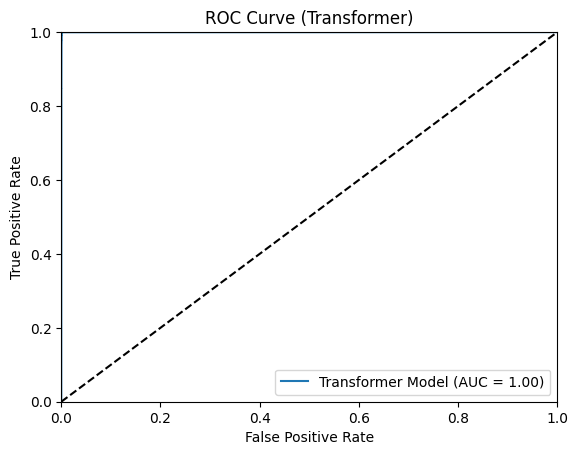

In [37]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='Transformer Model (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC Curve (Transformer)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


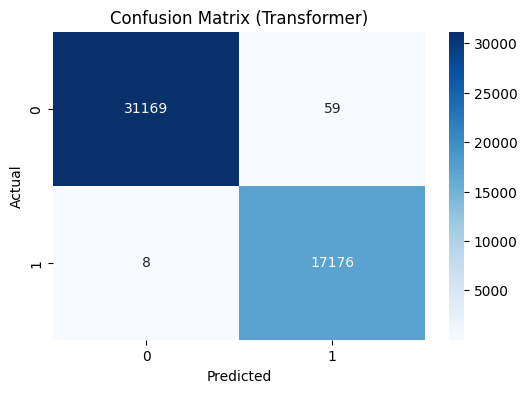

In [40]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Threshold the predicted probabilities to get class predictions
y_pred_classes = (y_pred_probs > 0.5).astype("int32")

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion Matrix (Transformer)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


In [41]:
# Classification report
report = classification_report(y_test, y_pred, output_dict=True)

print(f"Accuracy: {report['accuracy']:.3f}")
print(f"Precision: {report['1']['precision']:.3f}")
print(f"Recall: {report['1']['recall']:.3f}")
print(f"F1-Score: {report['1']['f1-score']:.3f}")


Accuracy: 0.999
Precision: 0.997
Recall: 1.000
F1-Score: 0.998
